In [15]:
import torch
from torch.utils.data import Dataset
from astropy.io import fits
import astropy.units as u
from astropy.time import Time

import numpy as np
from arccnet.visualisation import utils as ut_v
from scipy.ndimage import rotate
import sunpy.map
import pandas as pd
import os
from arccnet.models import labels
from arccnet.models import train_utils as ut_t

import torchvision
import torchvision.ops as ops
import torchvision.transforms.functional as TF
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torch
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torchvision import transforms
from p_tqdm import p_map

from matplotlib import pyplot as plt
img_size_dic = {'MDI': 1024, 'HMI': 4096}

In [16]:
data_folder = os.getenv('ARCAFF_DATA_FOLDER', '../../../data/')
dataset_folder = 'arccnet-fulldisk-dataset-v20240917'
df_name = 'fulldisk-detection-catalog-v20240917.parq'

local_path_root = os.path.join(data_folder, dataset_folder)

df = pd.read_parquet(os.path.join(data_folder, dataset_folder, df_name))
df['time'] = df['datetime.jd1'] + df['datetime.jd2']
times = Time(df['time'], format='jd')
df['datetime'] = pd.to_datetime(times.iso)

selected_df  = df[df['filtered'] == False]

lon_trshld = 70
front_df = selected_df[(selected_df['longitude'] < lon_trshld) & (selected_df['longitude'] > -lon_trshld)]

min_size = 0.024
img_size_dic = {
    'MDI': 1024,
    'HMI': 4096}

cleaned_df = front_df.copy()
for idx, row in cleaned_df.iterrows():
    x_min, y_min = row['bottom_left_cutout']
    x_max, y_max = row['top_right_cutout']

    img_sz = img_size_dic.get(row['instrument'])
    width = (x_max - x_min) / img_sz
    height = (y_max - y_min) / img_sz
    
    cleaned_df.at[idx, 'width'] = width
    cleaned_df.at[idx, 'height'] = height

cleaned_df = cleaned_df[(cleaned_df['width'] >= min_size) & (cleaned_df['height'] >= min_size)]

cleaned_df

,target_time.jd1,target_time.jd2,datetime.jd1,datetime.jd2,instrument,path,processed_path_image,target_time_arc.jd1,target_time_arc.jd2,datetime_arc.jd1,...,record_TARPNUM_arc,record_TARPNUM_arc.mask,record_HARPNUM_arc,record_HARPNUM_arc.mask,quicklook_path,quicklook_path.mask,time,datetime,width,height
30,2450262.0,0.5,2450263.0,-0.498958,MDI,arccnet_data/02_intermediate/data/mag/fits/mdi...,arccnet_data/03_processed/data/mag/fits/mdi/md...,2450262.0,0.5,2450263.0,...,52,False,0,True,arccnet_data/04_final/data/region_detection/qu...,False,2.450263e+06,1996-06-28 00:01:30.000,0.108398,0.062500
31,2450262.0,0.5,2450263.0,-0.498958,MDI,arccnet_data/02_intermediate/data/mag/fits/mdi...,arccnet_data/03_processed/data/mag/fits/mdi/md...,2450262.0,0.5,2450263.0,...,49,False,0,True,arccnet_data/04_final/data/region_detection/qu...,False,2.450263e+06,1996-06-28 00:01:30.000,0.082031,0.058594
32,2450264.0,-0.5,2450264.0,-0.498958,MDI,arccnet_data/02_intermediate/data/mag/fits/mdi...,arccnet_data/03_processed/data/mag/fits/mdi/md...,2450264.0,-0.5,2450264.0,...,49,False,0,True,arccnet_data/04_final/data/region_detection/qu...,False,2.450264e+06,1996-06-29 00:01:30.000,0.068359,0.059570
33,2450264.0,-0.5,2450264.0,-0.498958,MDI,arccnet_data/02_intermediate/data/mag/fits/mdi...,arccnet_data/03_processed/data/mag/fits/mdi/md...,2450264.0,-0.5,2450264.0,...,52,False,0,True,arccnet_data/04_final/data/region_detection/qu...,False,2.450264e+06,1996-06-29 00:01:30.000,0.110352,0.060547
34,2450264.0,0.5,2450265.0,-0.498958,MDI,arccnet_data/02_intermediate/data/mag/fits/mdi...,arccnet_data/03_processed/data/mag/fits/mdi/md...,2450264.0,0.5,2450265.0,...,49,False,0,True,arccnet_data/04_final/data/region_detection/qu...,False,2.450265e+06,1996-06-30 00:01:30.000,0.051758,0.059570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27389,2459818.0,0.5,2459818.0,0.499111,HMI,arccnet_data/02_intermediate/data/mag/fits/hmi...,arccnet_data/03_processed/data/mag/fits/hmi/hm...,2459818.0,0.5,2459818.0,...,0,True,8540,False,arccnet_data/04_final/data/region_detection/qu...,False,2.459818e+06,2022-08-26 23:58:43.200,0.146240,0.056396
27390,2459820.0,-0.5,2459819.0,0.499110,HMI,arccnet_data/02_intermediate/data/mag/fits/hmi...,arccnet_data/03_processed/data/mag/fits/hmi/hm...,2459820.0,-0.5,2459819.0,...,0,True,8540,False,arccnet_data/04_final/data/region_detection/qu...,False,2.459819e+06,2022-08-27 23:58:43.100,0.145508,0.057373
27391,2459820.0,-0.5,2459819.0,0.499110,HMI,arccnet_data/02_intermediate/data/mag/fits/hmi...,arccnet_data/03_processed/data/mag/fits/hmi/hm...,2459820.0,-0.5,2459819.0,...,0,True,8546,False,arccnet_data/04_final/data/region_detection/qu...,False,2.459819e+06,2022-08-27 23:58:43.100,0.186279,0.108398
27392,2459820.0,-0.5,2459819.0,0.499110,HMI,arccnet_data/02_intermediate/data/mag/fits/hmi...,arccnet_data/03_processed/data/mag/fits/hmi/hm...,2459820.0,-0.5,2459819.0,...,0,True,8539,False,arccnet_data/04_final/data/region_detection/qu...,False,2.459819e+06,2022-08-27 23:58:43.100,0.085937,0.064697


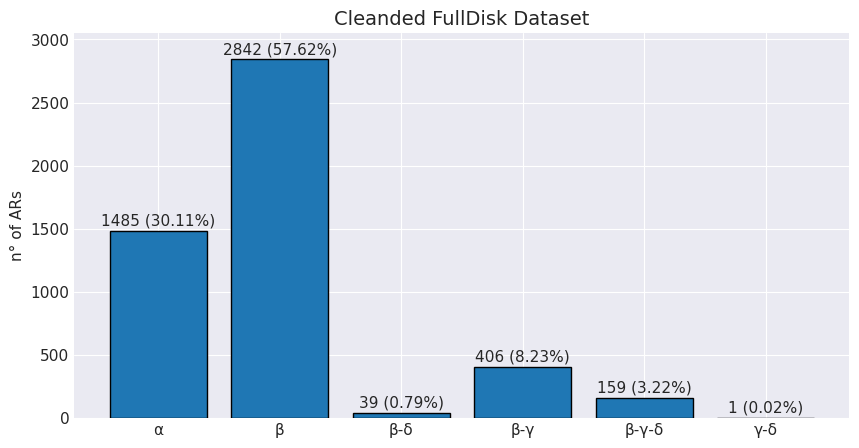

In [17]:
ut_v.make_classes_histogram(
    cleaned_df['magnetic_class'], 
    y_off=20, figsz=(10, 5), title='Cleanded FullDisk Dataset', ylim = 3050, bar_color='#1f77b4')

In [18]:
label_mapping = {
    "Alpha": "Alpha",
    "Beta": "Beta",
    "Beta-Delta": "Beta",
    "Beta-Gamma": "Beta-Gamma",
    "Beta-Gamma-Delta": "Beta-Gamma",
    "Gamma": "None",
    "Gamma-Delta": "None",
}

unique_labels = cleaned_df["magnetic_class"].map(label_mapping).unique()
label_to_index = {label: idx for idx, label in enumerate(unique_labels, start=1)}  # Start from 1

# Update DataFrame
cleaned_df["grouped_label"] = cleaned_df["magnetic_class"].map(label_mapping)
cleaned_df = cleaned_df[cleaned_df["grouped_label"] != "None"].copy()  # Exclude 'None' labels if necessary
cleaned_df["encoded_label"] = cleaned_df["grouped_label"].map(label_to_index)

In [19]:
split_idx = int(0.8 * len(cleaned_df))
train_df = cleaned_df[:split_idx]
val_df = cleaned_df[split_idx:]

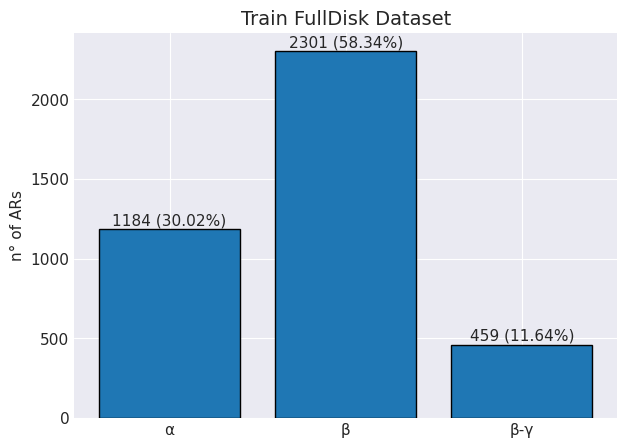

In [20]:
ut_v.make_classes_histogram(
    train_df['grouped_label'], 
    y_off=10, figsz=(7, 5), title='Train FullDisk Dataset', bar_color='#1f77b4')

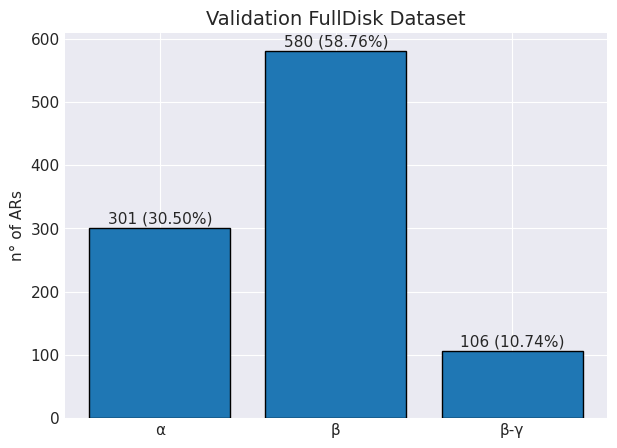

In [21]:
ut_v.make_classes_histogram(
    val_df['grouped_label'], 
    y_off=3, figsz=(7, 5), title='Validation FullDisk Dataset', bar_color='#1f77b4')

In [22]:
def preprocess_FD(row):
        arccnet_path_root = row["path"].split("/fits")[0]
        image_path = row["path"].replace(arccnet_path_root, local_path_root)

        with fits.open(image_path) as img_fit:
            data = img_fit[1].data
            header = img_fit[1].header
            
        data = np.nan_to_num(data, nan=0.0)
        data = ut_v.hardtanh_transform_npy(data)        
        crota2 = header['CROTA2']
        data = rotate(data, crota2, reshape=False, mode='constant', cval=0)

        return data

In [23]:
class FulldiskDataset(Dataset):
    def __init__(self, df, local_path_root, transform=None):
        self.df = df
        self.local_path_root = local_path_root
        self.transform = transform
        self.img_size_dic = img_size_dic  # Add this to use img size dictionary

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        final_size = 800 
        row = self.df.iloc[idx]
        data = preprocess_FD(row)
        data = ut_v.pad_resize_normalize(data, target_height=final_size, target_width=final_size)
        data = torch.tensor(data, dtype=torch.float32).unsqueeze(0)  # Add channel dimension

        if self.transform:
            data = self.transform(data)

        label = row['encoded_label']

        # Compute bounding box
        img_sz = img_size_dic.get(row['instrument'])
        scale_factor = final_size / img_sz
        x_min, y_min = row['bottom_left_cutout']
        x_max, y_max = row['top_right_cutout']
        bbox = [
            x_min * scale_factor,
            y_min * scale_factor,
            x_max * scale_factor,
            y_max * scale_factor,
        ]  # Absolute coordinates
        area = (bbox[2] - bbox[0]) * (bbox[3] - bbox[1])

        # Structure for Faster R-CNN
        target = {
            'boxes': torch.tensor([bbox], dtype=torch.float32),
            'labels': torch.tensor([label], dtype=torch.int64),
        }

        return data, target

In [24]:
num_classes = 1 + len(unique_labels)
def faster_rcnn_model():
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='DEFAULT')

    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    #model.backbone.body.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    return model

In [25]:
device = ut_t.get_device()
model = faster_rcnn_model()
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [26]:
# Training parameters
num_epochs = 20
learning_rate = 0.005
weight_decay = 0.0005
step_size = 5
gamma = 0.1
batch_size = 4

train_dataset = FulldiskDataset(train_df, local_path_root)
val_dataset = FulldiskDataset(val_df, local_path_root)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=16, pin_memory=True, collate_fn=lambda x: list(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=16, pin_memory=True, collate_fn=lambda x: list(zip(*x)))
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=weight_decay)
scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)

In [27]:
data_iter = iter(train_loader)
images, labels = next(data_iter)

In [37]:
def train_one_epoch(model, optimizer, data_loader, device):
    model.train()
    total_loss = 0.0
    for images, targets in tqdm(data_loader, desc="Training", leave=False):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        
        # Backward pass
        losses.backward()
        optimizer.step()
        
        total_loss += losses.item()
    
    return total_loss / len(data_loader)

def evaluate(model, data_loader, device):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for images, targets in tqdm(data_loader, desc="Validation", leave=False):
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            # Calculate validation loss by temporarily switching to training mode
            model.train()
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            total_loss += losses.item()
            model.eval()

    return total_loss / len(data_loader)

In [29]:
# Training loop
best_val_loss = float('inf')
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    
    # Train for one epoch
    train_loss = train_one_epoch(model, optimizer, train_loader, device)
    print(f"Train Loss: {train_loss:.4f}")
    
    # Evaluate on validation set
    val_loss = evaluate(model, val_loader, device)
    print(f"Validation Loss: {val_loss:.4f}")
    
    # Update learning rate
    scheduler.step()
    
    # Save the model if validation loss has decreased
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_fasterrcnn_model.pth")
        print("Model saved.")

print("Training complete.")

Epoch 1/20


Training:   0%|          | 0/986 [00:00<?, ?it/s]

Train Loss: 0.2146


AttributeError: 'list' object has no attribute 'values'

In [35]:
model.eval()
total_loss = 0.0
with torch.no_grad():
    for images, targets in tqdm(val_loader, desc="Validation", leave=False):
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            # Forward pass (calculate loss during evaluation)
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            total_loss += losses.item()
        

AttributeError: 'list' object has no attribute 'values'

In [36]:
loss_dict

[{'boxes': tensor([[371.0822, 464.7007, 474.9062, 505.5035],
          [371.9935, 466.2800, 478.1764, 507.5598],
          [500.3961, 254.2275, 550.7206, 290.1456],
          [500.9405, 255.7695, 546.8090, 287.8936]], device='cuda:0'),
  'labels': tensor([2, 1, 1, 2], device='cuda:0'),
  'scores': tensor([0.5280, 0.2851, 0.2728, 0.2649], device='cuda:0')},
 {'boxes': tensor([[461.7665, 472.3982, 557.4434, 507.0555],
          [462.0900, 471.8418, 551.2841, 505.7270],
          [ 85.0618, 202.8905, 123.4341, 262.8307],
          [579.0554, 265.4586, 622.2981, 289.8445],
          [580.2826, 265.3979, 620.5770, 290.9959],
          [ 86.2913, 202.9377, 119.6030, 259.3413]], device='cuda:0'),
  'labels': tensor([1, 2, 1, 1, 2, 2], device='cuda:0'),
  'scores': tensor([0.3447, 0.2366, 0.1628, 0.1211, 0.0979, 0.0726], device='cuda:0')},
 {'boxes': tensor([[461.7665, 472.3982, 557.4434, 507.0555],
          [462.0900, 471.8418, 551.2841, 505.7270],
          [ 85.0618, 202.8905, 123.4341, 26